<a href="https://colab.research.google.com/github/dmosh/cvexam/blob/main/Crop_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this practical examination you will complete a significant project in computer vision that uses material that you learned in the course. The goal of this project is to perform banana crop detection from a set of garden images.

We follow a set of step for this classification
1. Images are changed into grayscale
2. For each image, generate its feature descriptor while using SIFT
3. Stack the features vertically to create a NumPy array (feature array)
4. Perform k-means clustering on the feature array to obtain the centers of the centroid.
5. Uses the centers obtained to perform a bag of features. This assigns the features which are similar to a specific cluster.
6. Split the dataset formed at step 5 into train and test sets at an 80:20 ratio respectively.
7. Naive Bayes for each threshold needed for the SIFT until you obtain a good classification.
8. Evaluate the classifications using accuracy, precision, recall, F1





In [1]:
# mounting the drive to read the files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing necessary libraries
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt
from skimage import io
import PIL
import PIL.Image
from skimage import filters
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import time

In [6]:
# reading cropped images from Banana and cassava
import pathlib
data = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CV/dataset/annotated/ml dataset/Maize')
maize_images = list(data.glob('*.jpg'))
data = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CV/dataset/annotated/ml dataset/Cassava')
cassava_images = list(data.glob('*.jpg'))
data = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/CV/dataset/annotated/ml dataset/Coffee')
coffee_images = list(data.glob('*.jpg'))
#print(len(coffee_images))

31


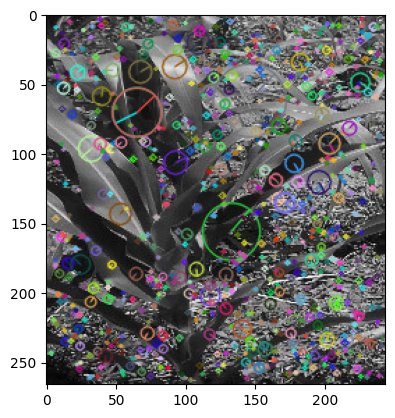

In [8]:
# using SIFT to extract features
img = cv2.imread(str(maize_images[0]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#plt.imshow(gray)
kp = sift.detect(gray, None)

# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

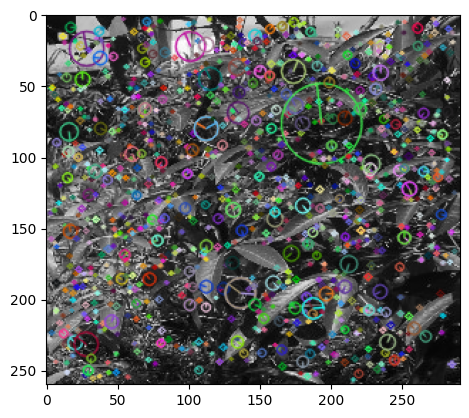

In [10]:
# using SIFT to extract features for cassava
img = cv2.imread(str(cassava_images[4]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kp = sift.detect(gray, None)

# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

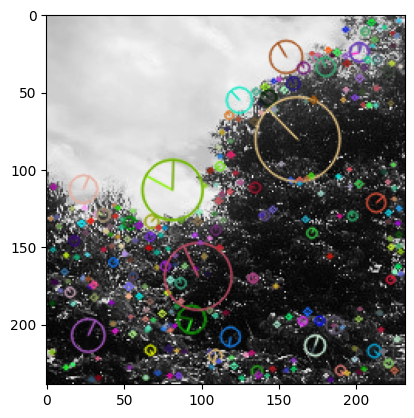

In [11]:
# using SIFT to extract features
img = cv2.imread(str(coffee_images[9]))
sift = cv2.xfeatures2d.SIFT_create()
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
kp = sift.detect(gray, None)

# Marking the keypoint on the image using circles
sift_img=cv2.drawKeypoints(gray ,
                      kp ,
                      img ,
                      flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(sift_img)

In [12]:
# getting features for different thresholds
def get_k_shift_thresh(thresh):
  def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des

  features = []
  for file in maize_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)

  for file in coffee_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  features = np.vstack(features)

  return features

In [13]:
# getting the features per threshold
features_per_threshold = {}
for i in range(5,26,5):
  features_per_threshold[i] = get_k_shift_thresh(i)

**Method structure**
Combining all the above steps into one main algorithim

In [16]:
from sklearn.naive_bayes import GaussianNB

def sift_svm_naive_classifier(thresh):

  t0 = time.time()

  def CalcFeatures(img, th):
    sift = cv2.xfeatures2d.SIFT_create(th)
    kp, des = sift.detectAndCompute(img, None)
    return des

  '''
  All the files appended to the image_path list are passed through the
  CalcFeatures functions which returns the descriptors which are
  appended to the features list and then stacked vertically in the form
  of a numpy array.
  '''

  features = []
  for file in maize_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  for file in coffee_images:
    img = cv2.imread(str(file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      features.append(img_des)
  features = np.vstack(features)

  '''
  K-Means clustering is then performed on the feature array obtained
  from the previous step. The centres obtained after clustering are
  further used for bagging of features.
  '''

  k = 150
  criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.1)
  flags = cv2.KMEANS_RANDOM_CENTERS
  compactness, labels, centres = cv2.kmeans(features, k, None, criteria, 10, flags)

  '''
  The bag_of_features function assigns the features which are similar
  to a specific cluster centre thus forming a Bag of Words approach.
  '''

  def bag_of_features(features, centres, k = 500):
      vec = np.zeros((1, k))
      for i in range(features.shape[0]):
          feat = features[i]
          diff = np.tile(feat, (k, 1)) - centres
          dist = pow(((pow(diff, 2)).sum(axis = 1)), 0.5)
          idx_dist = dist.argsort()
          idx = idx_dist[0]
          vec[0][idx] += 1
      return vec

  labels = []
  vec = []
  for file in maize_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(0)
  for file in cassava_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(1)
  for file in coffee_images:
    img = cv2.imread(str(file))
    img_des = CalcFeatures(img, thresh)
    if img_des is not None:
      img_vec = bag_of_features(img_des, centres, k)
      vec.append(img_vec)
      labels.append(2)
  vec = np.vstack(vec)

  '''
  Splitting the data formed into test and split data and training the
  SVM Classifier.
  '''

  X_train, X_test, y_train, y_test = train_test_split(vec, labels, test_size=0.2)
  clf = SVC()
  clf.fit(X_train, y_train)
  preds = clf.predict(X_test)
  acc = accuracy_score(y_test, preds)
  conf_mat = confusion_matrix(y_test, preds)
  # plt.imshow(conf_mat, cmap='binary')

  clf_g = GaussianNB()
  clf_g.fit(X_train, y_train)
  preds_g = clf_g.predict(X_test)
  acc_g = accuracy_score(y_test, preds_g)
  conf_mat_g = confusion_matrix(y_test, preds_g)


  t1 = time.time()

  return acc*100, conf_mat, (t1-t0), acc_g*100, conf_mat_g


accuracy = {}
accuracy_g = {}
conf_mat_lst = {}
conf_mat_lst_g = {}
timer = []
# data_analysis = {}
for i in range(5,26,5):
  print('\nCalculating for a threshold of {}'.format(i))
  data = sift_svm_naive_classifier(i)
  # accuracy.append(data[0])
  accuracy[i] = data[0]
  accuracy_g[i] = data[3]
  conf_mat = data[1]
  conf_mat_lst[i] = data[1]
  conf_mat_lst_g[i] = data[4]
  timer.append(data[2])
  print('\nSVM\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix :\n{}'.format(data[0],data[2],data[1]))
  print('\nNaive Bayes\nAccuracy = {}\nTime taken = {} sec\nConfusion matrix :\n{}'.format(data[3],data[2],data[4]))


Calculating for a threshold of 5

SVM
Accuracy = 53.44827586206896
Time taken = 53.15502429008484 sec
Confusion matrix :
[[22  6  0]
 [16  9  0]
 [ 1  4  0]]

Naive Bayes
Accuracy = 41.37931034482759
Time taken = 53.15502429008484 sec
Confusion matrix :
[[ 8 12  8]
 [ 6 12  7]
 [ 0  1  4]]

Calculating for a threshold of 10

SVM
Accuracy = 63.793103448275865
Time taken = 55.772162199020386 sec
Confusion matrix :
[[27  3  0]
 [15 10  0]
 [ 3  0  0]]

Naive Bayes
Accuracy = 36.206896551724135
Time taken = 55.772162199020386 sec
Confusion matrix :
[[14 12  4]
 [ 6  6 13]
 [ 1  1  1]]

Calculating for a threshold of 15

SVM
Accuracy = 58.620689655172406
Time taken = 54.83236527442932 sec
Confusion matrix :
[[22  6  0]
 [10 12  1]
 [ 4  3  0]]

Naive Bayes
Accuracy = 60.3448275862069
Time taken = 54.83236527442932 sec
Confusion matrix :
[[19  2  7]
 [ 7  9  7]
 [ 0  0  7]]

Calculating for a threshold of 20

SVM
Accuracy = 56.896551724137936
Time taken = 55.632211208343506 sec
Confusion ma

In [17]:
sum(accuracy.values())/len(accuracy.values())

58.27586206896551

In [18]:
sum(accuracy_g.values())/len(accuracy_g.values())


46.55172413793103

In [19]:
conf_mat_lst

{5: array([[22,  6,  0],
        [16,  9,  0],
        [ 1,  4,  0]]),
 10: array([[27,  3,  0],
        [15, 10,  0],
        [ 3,  0,  0]]),
 15: array([[22,  6,  0],
        [10, 12,  1],
        [ 4,  3,  0]]),
 20: array([[19,  7,  0],
        [10, 14,  0],
        [ 6,  2,  0]]),
 25: array([[22, 12,  0],
        [11, 10,  0],
        [ 0,  1,  2]])}

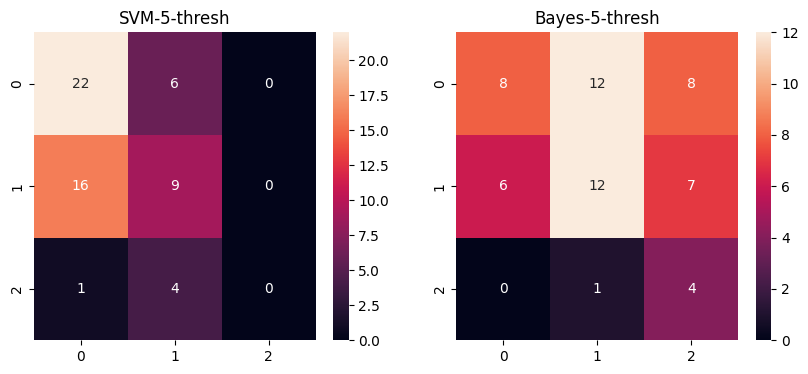

In [20]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[5], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[5], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-5-thresh')
ax2.set_title('Bayes-5-thresh')
plt.show()

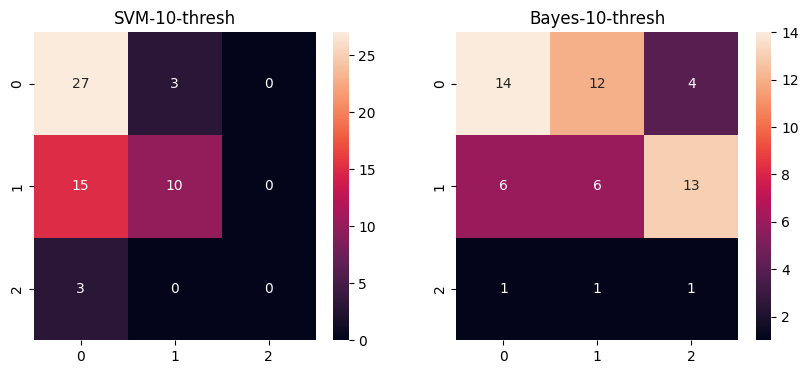

In [21]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[10], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[10], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-10-thresh')
ax2.set_title('Bayes-10-thresh')
plt.show()

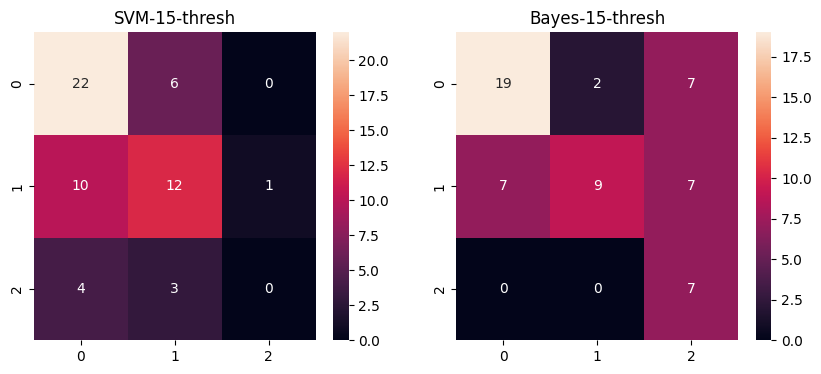

In [22]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[15], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[15], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-15-thresh')
ax2.set_title('Bayes-15-thresh')
plt.show()

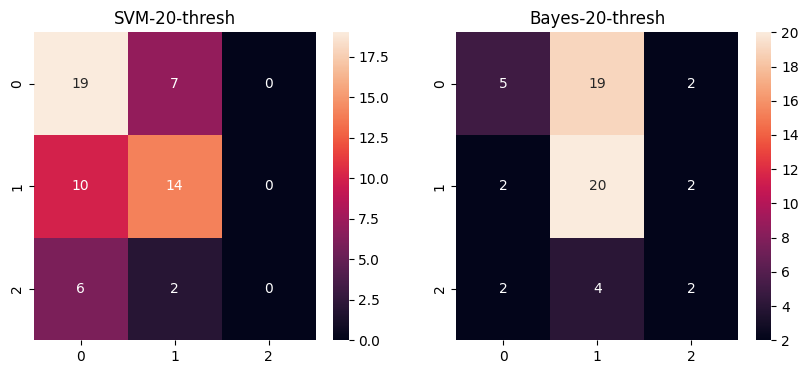

In [23]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[20], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[20], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-20-thresh')
ax2.set_title('Bayes-20-thresh')
plt.show()

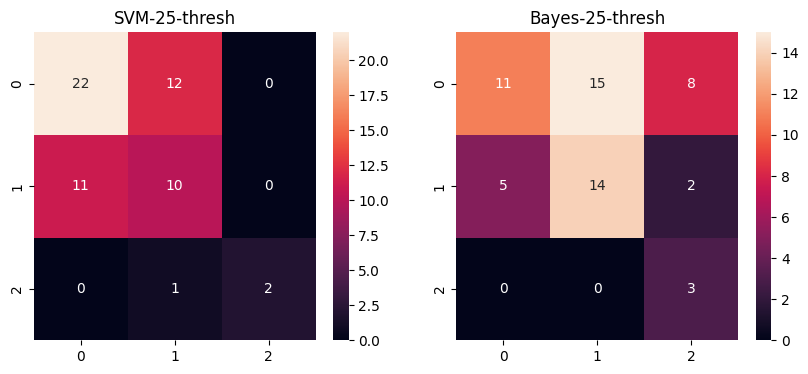

In [24]:
import seaborn as sns
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 4))
sns.heatmap(conf_mat_lst[25], annot=True, fmt='g',ax=ax1)
sns.heatmap(conf_mat_lst_g[25], annot=True, fmt='g',ax=ax2)
ax1.set_title('SVM-25-thresh')
ax2.set_title('Bayes-25-thresh')
plt.show()

In [25]:
# comparing there accuracys
import pandas as pd
combined_dict = {"svm":accuracy, "bayes":accuracy_g}
combined_dict
df = pd.DataFrame(combined_dict)
df

,svm,bayes
5,53.448276,41.379310
10,63.793103,36.206897
15,58.620690,60.344828
20,56.896552,46.551724
25,58.620690,48.275862


In [ ]:
from sklearn.naive_bayes import GaussianNB

Text(0.5, 0, 'SIFT-Threshold')

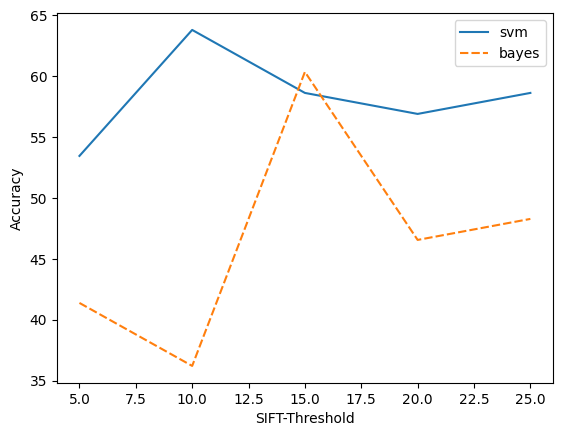

In [26]:
plot = sns.lineplot(data=df)
plot.set_ylabel("Accuracy")
plot.set_xlabel("SIFT-Threshold")
